# Overfitting a small encoder-only classifier to a dataset. Not using a validation set since i'm mostly just interested in getting the transformer architecture training and not its actual performance or how well it generalizes on this problem

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ratings/Womens_Clothing_E-Commerce_Reviews_CLEANED.csv


In [2]:
%rm -r transformer_from_scratch
!git clone https://github.com/culv/transformer_from_scratch.git
%cd transformer_from_scratch

rm: cannot remove 'transformer_from_scratch': No such file or directory
Cloning into 'transformer_from_scratch'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 84 (delta 44), reused 66 (delta 29), pack-reused 0
Unpacking objects: 100% (84/84), 97.56 KiB | 3.15 MiB/s, done.
/kaggle/working/transformer_from_scratch


In [3]:
from data_utils import Gpt2Tokenizer
t = Gpt2Tokenizer

print(len(t))
print(t.vocab_size)
print(t.mask_token)
print(t.eos_token)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

50257
50257
None
<|endoftext|>


In [4]:
from transformer_from_scratch.data_utils import BalancedClassRandomSampler, PandasDataset, tokenize

data_path = "/kaggle/input/ratings/Womens_Clothing_E-Commerce_Reviews_CLEANED.csv"
ds = PandasDataset(
    data_path,
    input_column="review",
    output_column="Recommended IND",
    input_transform=tokenize(160)
)
print(ds[111])

((tensor([ 7279,  1324,  1563,   278,  3081,   383,  1486,    14, 43358,   286,
          262,  6576,   389,  2407, 48259,    11,   781,  5893,   290, 23564,
           13,   475,  1106,   612,   318,   645,   835,   326,   262,  6576,
         1312,  2722,   318,   649,    13,   262,  3124,   318,   257, 24887,
        18989,   503,  2266,   290,   612,   389,  2042, 43329,   477,   625,
          262, 10999,  1989,    13,   612,   318,   645,  7621,   986,   262,
         9664,  3073,  3102, 11081,   290, 22138,  1068,   290,   318,   407,
        23453,    11, 15175,   393,   649,    13,  1312,   716,   845, 11679,
          416,   262,  3081,   286,   262,  2378,   326,  1312,  2722,    13,
        17713,   428,   530,   318,  1016,   736,    13,   198,   198,    67,
          451, 21538,   532,  3387,   787,  1654,   326,   345,   466,   407,
         3758,   662,    12,   322,   437,  9528,  6685,   284, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256

In [7]:
from torch.utils.data import DataLoader

balanced_sampler = BalancedClassRandomSampler(ds.df[ds.output_column])

dl = DataLoader(ds, batch_size=64, sampler=balanced_sampler)#, shuffle=True)
for (x, m), y in dl:
    print(m)
    print(m.shape)
    print(y)
    print(y.shape)
    break

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
torch.Size([64, 160])
tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([64])


In [8]:
import torch
import torch.nn as nn

from models import EncoderOnlyClassifier

num_heads = 8
d_model = 256
seq_len = 160

model = EncoderOnlyClassifier(
    num_classes=2,
    num_encoders = 6,
    num_heads = 8,
    d_model = d_model,
    seq_len = seq_len
)

loss_fn = nn.CrossEntropyLoss()
lr = 0.00025  # a pretty low learning rate seems to work best
opt = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(f"{device=}")
model.to(device=device)

log_loss_every = 100

i = 0
for epoch in range(5):
    for (x, m), y in dl:
        
        x = x.to(device=device)
        m = m.to(device=device)
        m = m.unsqueeze(-1) * m.unsqueeze(-2)
        y = y.to(device=device)
        
        opt.zero_grad()

        out = model(x, m)
                
        loss = loss_fn(out, y)
        
        loss.backward()
                
        opt.step()

        if i % log_loss_every == 0:
            y_pred = out.argmax(dim=-1)
            
            pos_ids = torch.nonzero(y)
            neg_ids = torch.nonzero(1-y)

            true_pos = (y_pred[pos_ids] == 1).float().sum()
            false_pos = (y_pred[neg_ids] == 1).float().sum()
            true_neg = (y_pred[neg_ids] == 0).float().sum()
            false_neg = (y_pred[pos_ids] == 0).float().sum()

            precision = true_pos / (true_pos + false_pos)
            recall = true_pos / (true_pos + false_neg)
            accuracy = (true_pos + true_neg) / len(y)

            print(
                f"epoch={epoch}, iter={i}, loss={loss.detach().cpu():.4f}, "
                f"accuracy={accuracy.detach().cpu():.4f}, precision={precision.detach().cpu():.4f}, "
                f"recall={recall.detach().cpu():.4f}"
            )
        i += 1

device=device(type='cuda')
epoch=0, iter=0, loss=0.7960, accuracy=0.3906, precision=0.2500, recall=0.1290
epoch=0, iter=100, loss=0.6502, accuracy=0.6562, precision=0.6047, recall=0.8387
epoch=0, iter=200, loss=0.3356, accuracy=0.8594, precision=0.9000, recall=0.8182
epoch=0, iter=300, loss=0.3754, accuracy=0.8906, precision=0.8571, recall=0.8889
epoch=1, iter=400, loss=0.2589, accuracy=0.9219, precision=0.8276, recall=1.0000
epoch=1, iter=500, loss=0.1130, accuracy=0.9531, precision=0.9706, recall=0.9429
epoch=1, iter=600, loss=0.1944, accuracy=0.9219, precision=0.8788, recall=0.9667
epoch=1, iter=700, loss=0.2862, accuracy=0.9062, precision=1.0000, recall=0.8065
epoch=2, iter=800, loss=0.2026, accuracy=0.9062, precision=0.9459, recall=0.8974
epoch=2, iter=900, loss=0.2906, accuracy=0.9375, precision=0.9677, recall=0.9091
epoch=2, iter=1000, loss=0.0397, accuracy=0.9844, precision=0.9677, recall=1.0000
epoch=3, iter=1100, loss=0.1449, accuracy=0.9375, precision=1.0000, recall=0.8621
e

interactive(children=(IntSlider(value=24, description='batch_element', max=49), IntSlider(value=3, description…

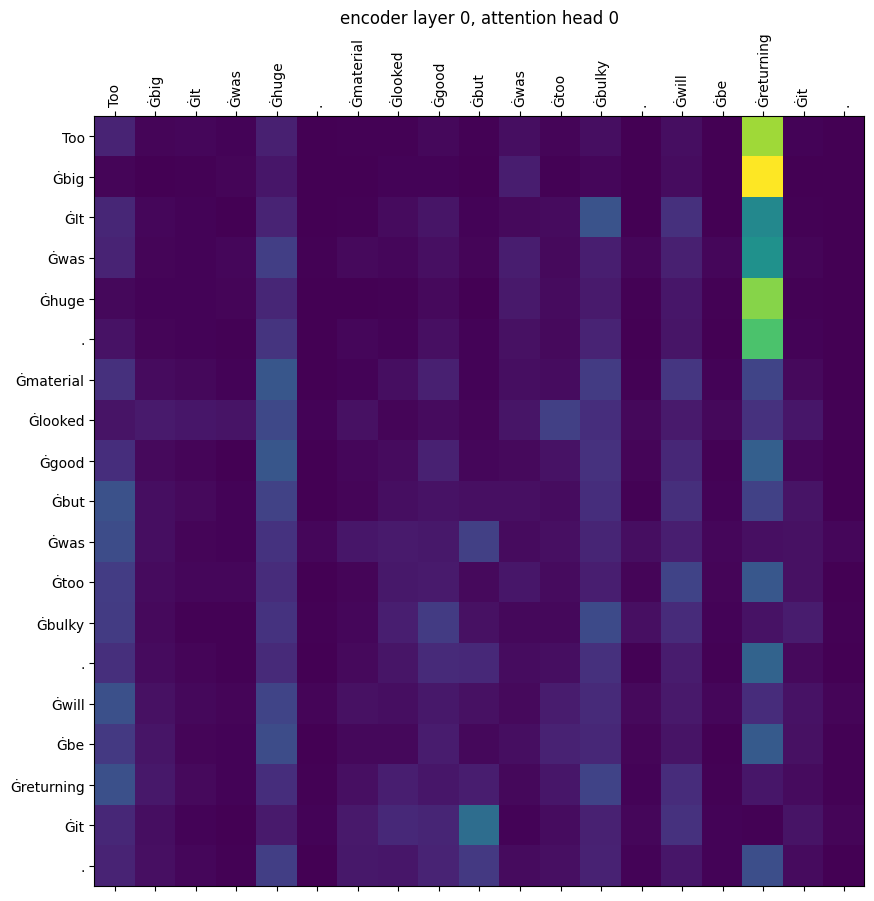

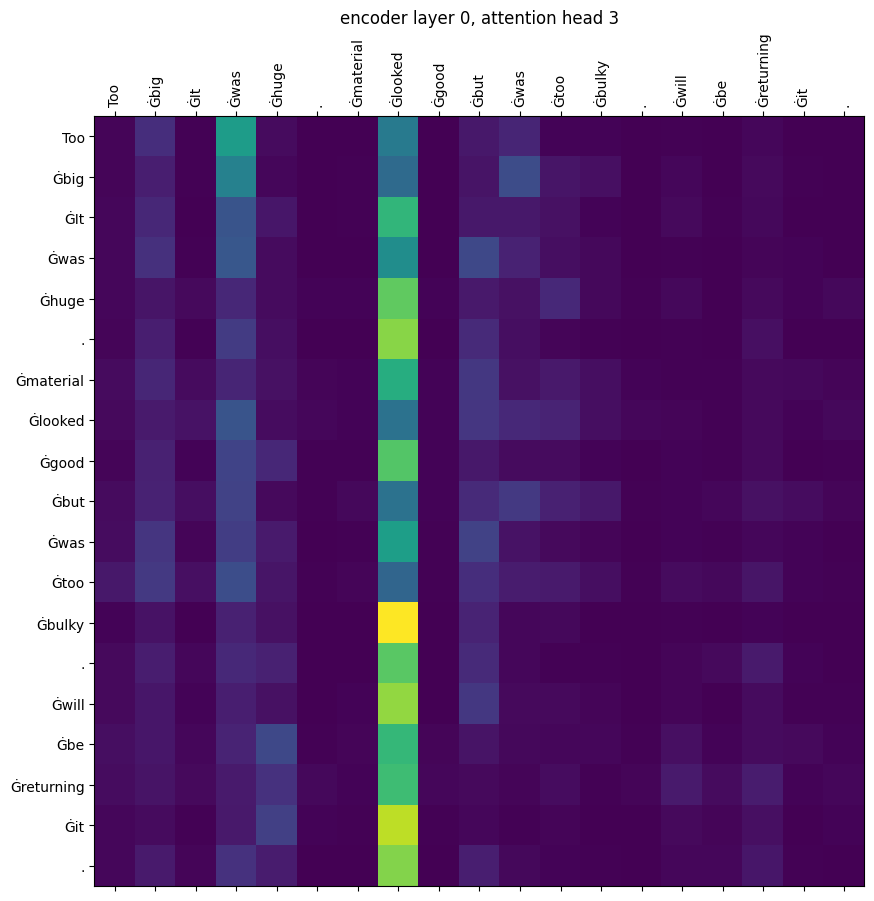

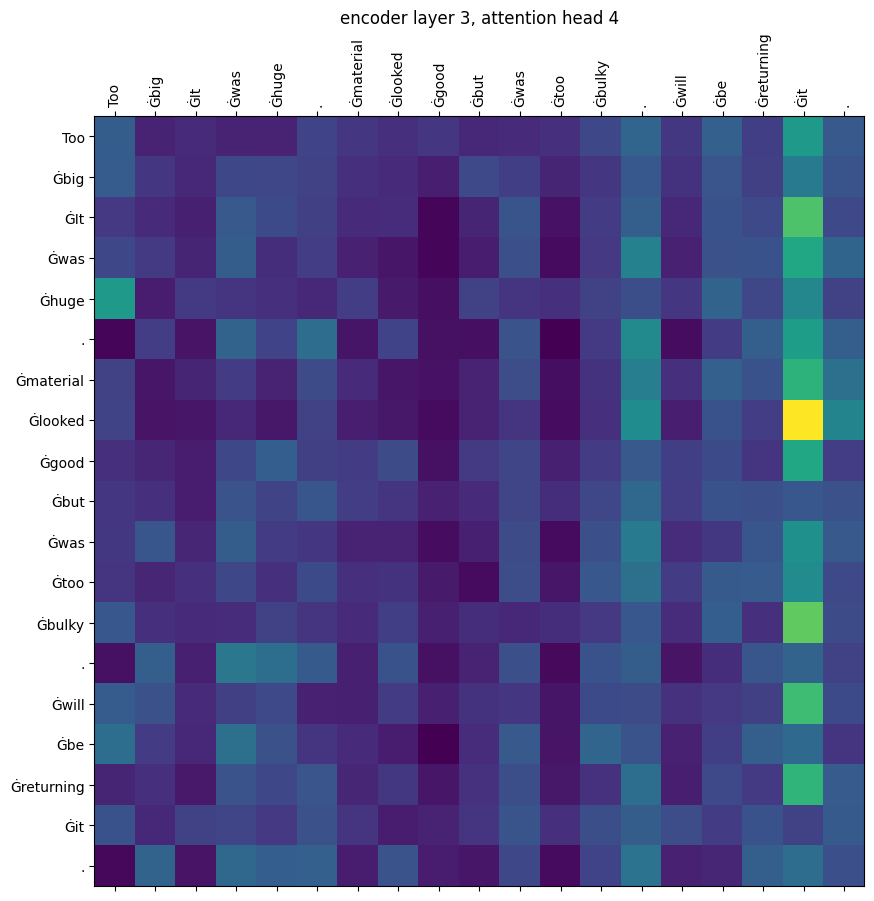

In [23]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np

# Moving stuff to CPU so we dont have to do it each time we adjust the visualization sliders
x_ = x.cpu()
attns = []
for enc_layer in model.encoder.encoder_layers:
    layer_attns = []
    for head in enc_layer.multihead_self_attention.attentions:
        layer_attns.append(head.detach().cpu())
    attns.append(layer_attns)


def visualize_attention(batch_element, attention_head, encoder_layer):
    inp = t.convert_ids_to_tokens(x_[batch_element])
    lim = (x_[batch_element] == 50256).to(int).argmax().item()

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(attns[encoder_layer][attention_head][batch_element][:lim,:lim])
    ax.set_yticks(np.arange(0, lim));#seq_len));
    ax.set_yticklabels(inp[:lim]);
    ax.set_xticks(np.arange(0, lim));#seq_len));
    ax.set_xticklabels(inp[:lim], rotation="vertical");
    ax.set_title(f"encoder layer {encoder_layer}, attention head {attention_head}");

interact(visualize_attention, attention_head=(0,7,1), batch_element=(0,x_.shape[0]-1,1), encoder_layer=(0,5,1))
visualize_attention(35, 0, 0)
visualize_attention(35, 3, 0)
visualize_attention(35, 4, 3)

interactive(children=(IntSlider(value=24, description='batch_element', max=49), Output()), _dom_classes=('widg…

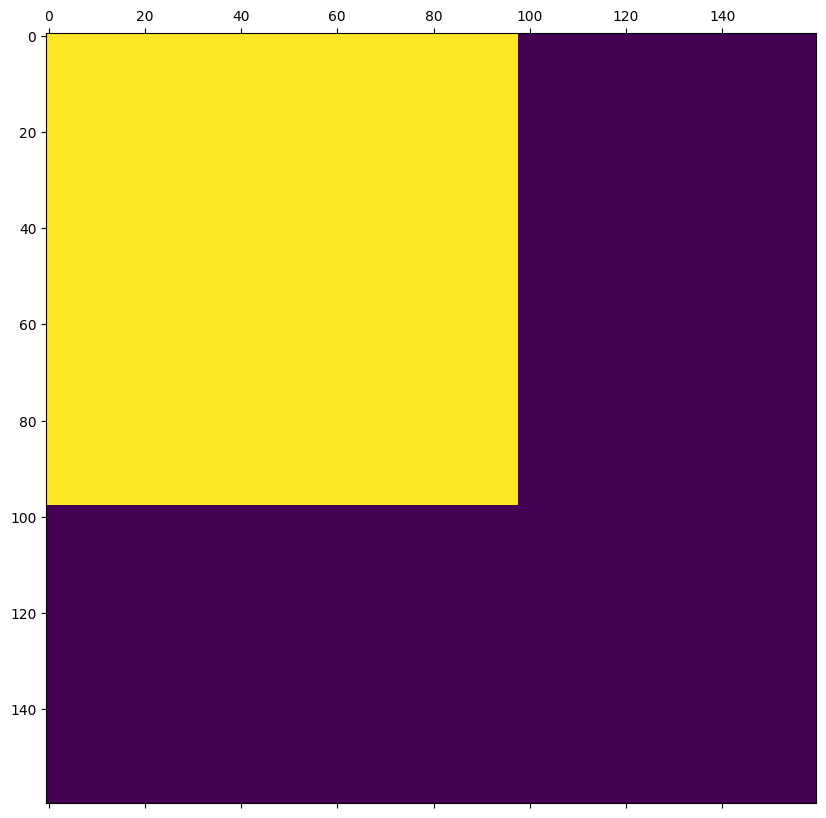

In [24]:
def visualize_mask(batch_element):
#     inp = t.convert_ids_to_tokens(x[batch_element])
#     lim = (x[batch_element] == 50256).to(int).argmax().item()
    m_cpu = m.cpu().detach()

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(m_cpu[batch_element])
#     ax.set_yticks(np.arange(0, lim));#seq_len));
#     ax.set_yticklabels(inp[:lim]);
#     ax.set_xticks(np.arange(0, lim));#seq_len));
#     ax.set_xticklabels(inp[:lim], rotation="vertical");

interact(visualize_mask, batch_element=(0,m.shape[0]-1,1))
visualize_mask(43)